In [1]:
import torch
from torch import nn
from torch.autograd import Variable

import torchvision.transforms as tfs
from torch.utils.data import DataLoader, sampler
from torchvision.datasets import MNIST
import torchvision
import torchvision.utils as vutils
import os
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
IMG_SIZE = 96
BATCH_SIZE = 64
NOISE_DIM = 100
DATA_DIR = 'data/' # data/faces/xxx.jpg (train dataset)
OUT_DIR = 'fake_images'# data/fake_images/xxx.jpg (store the generated pics)

### images importing and pre-processing

In [4]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(IMG_SIZE),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
 ])

dataset = torchvision.datasets.ImageFolder(DATA_DIR, transform=transforms)

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

### network of GAN

In [5]:
class discriminator_dc(nn.Module):
    def __init__(self):
        super(discriminator_dc, self).__init__()
        self.conv1 = nn.Sequential(#input 3x96x96
            nn.Conv2d(3, 64, 5, 3, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
        )# 64 x 32 x 32
        self.conv2 = nn.Sequential(#input 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )# 128 x 16 x 16
        self.conv3 = nn.Sequential(# 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )# 256 x 8 x 8
        self.fc = nn.Sequential(
            nn.Linear(256*8*8, 1024),
            nn.LeakyReLU(0.01),
            nn.Linear(1024, 1)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x


class generator_dc(nn.Module): 
    def __init__(self, noise_dim=NOISE_DIM):
        super(generator_dc, self).__init__()
        self.fc = nn.Sequential(# 100,
            nn.Linear(noise_dim, 1024), # 1024
            nn.ReLU(True),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 4 * 4 * 512),# 8*8*512
            nn.ReLU(True),
            nn.BatchNorm1d(4 * 4 * 512)
        )
        
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 4, 2, padding=1),# 128 x  8 x 8
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 4, 2, padding=1),# 32 x  16 x 16
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 4, 2, padding=1),# 3 x  32 x 32
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, 5, 3, padding=1),# 3 x  96 x 96
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], 512, 4, 4) # reshape channel is 512，shape 4 x 4
        x = self.conv(x) # [b,3,96,28]
        return x

### define loss function

In [6]:
bce_loss = nn.BCEWithLogitsLoss()

def discriminator_loss(real_preds,fake_preds):
    size = real_preds.shape[0]
    true_labels = torch.ones(size,1).float().cuda()
    false_labels = torch.zeros(size,1).float().cuda()
    loss = bce_loss(real_preds,true_labels) + bce_loss(fake_preds,false_labels)
    return loss

def generator_loss(fake_preds):
    size = fake_preds.shape[0]
    true_labels = torch.ones(size,1).float().cuda()
    loss = bce_loss(fake_preds,true_labels)
    return loss

def get_adam_optimizer(net):
    optimizer = torch.optim.Adam(net.parameters(), lr=3e-4, betas=(0.5, 0.999))
    return optimizer
def get_sgd_optimizer(net):
    optimizer = torch.optim.SGD(params=net.parameters(), lr=1e-3,momentum = 0.9,weight_decay=1e-4)
    return optimizer

### define training procedure

In [7]:
def train(data_iter,D_net,G_net,D_opt,G_opt,d_loss_func,g_loss_func,noise_size = 100,EPOCH = 10,show_every = 50):
    iter_count = 0
    
    loss = {'d': [], 'g': []}
    
    for epoch in range(EPOCH):
        for x,_ in data_iter:
            #batch_size = x.shape[0]
            
            #Discriminator
            #real_data = x.view(batch_size, -1).cuda()
            real_data = x.cuda()
            
            real_preds = D_net(real_data) 
            
            sample_noise = (torch.rand(BATCH_SIZE, noise_size) - 0.5) / 0.5 # -1 ~ 1
            fake_inputs = sample_noise.cuda() 
            
            fake_images = G_net(fake_inputs) 
            fake_preds = D_net(fake_images) 
            
            d_loss = d_loss_func(real_preds,fake_preds)
            
            #optimize discriminator
            D_opt.zero_grad()
            d_loss.backward()
            D_opt.step()

            #generator
            fake_inputs = sample_noise.cuda()
            fake_images = G_net(fake_inputs) 
            fake_preds = D_net(fake_images)
            g_loss = g_loss_func(fake_preds)
            #optimize generator
            G_opt.zero_grad()
            g_loss.backward()
            G_opt.step()
            
            loss['d'].append(d_loss.cpu().data.numpy())
            loss['g'].append(g_loss.cpu().data.numpy())
            
            if (iter_count % show_every == 0):
                print('Epoch: {},Iter: {}, D: {:.4}, G:{:.4}'.format(epoch,iter_count, d_loss.cpu().data.numpy(), g_loss.cpu().data.numpy()))
            iter_count += 1
        vutils.save_image(fake_images.data.cpu(),
                  '%s/fake_samples_epoch_%03d.png' % (os.path.join(DATA_DIR, OUT_DIR), epoch),
                  normalize=True)
 
        #torch.save(G_net.state_dict(), '%s/netG_%03d.pth' % (DATA_DIR, epoch))
        #torch.save(D_net.state_dict(), '%s/netD_%03d.pth' % (DATA_DIR, epoch))

    # plot the loss function versus number of iterations
    plt.plot(loss['d'], label='Discriminator')
    plt.plot(loss['g'], label='Generator')
    plt.legend(loc='upper right')
    plt.savefig('Loss.png')
    plt.show()

Epoch: 0,Iter: 0, D: 1.374, G:1.921
Epoch: 0,Iter: 250, D: 0.6867, G:1.854
Epoch: 0,Iter: 500, D: 0.7095, G:1.703
Epoch: 0,Iter: 750, D: 0.7132, G:2.441
Epoch: 1,Iter: 1000, D: 0.5004, G:2.68
Epoch: 1,Iter: 1250, D: 0.5819, G:2.183
Epoch: 1,Iter: 1500, D: 0.3666, G:3.507
Epoch: 2,Iter: 1750, D: 0.3668, G:2.807
Epoch: 2,Iter: 2000, D: 0.6186, G:2.757
Epoch: 2,Iter: 2250, D: 0.5717, G:3.968
Epoch: 3,Iter: 2500, D: 2.382, G:1.052
Epoch: 3,Iter: 2750, D: 0.3752, G:2.114
Epoch: 3,Iter: 3000, D: 0.4061, G:2.967
Epoch: 4,Iter: 3250, D: 0.3437, G:4.579
Epoch: 4,Iter: 3500, D: 1.755, G:2.056
Epoch: 4,Iter: 3750, D: 0.3385, G:3.002
Epoch: 5,Iter: 4000, D: 0.2787, G:5.929
Epoch: 5,Iter: 4250, D: 0.4142, G:4.775
Epoch: 5,Iter: 4500, D: 0.3211, G:2.949
Epoch: 5,Iter: 4750, D: 0.2508, G:3.983
Epoch: 6,Iter: 5000, D: 0.3963, G:7.687
Epoch: 6,Iter: 5250, D: 0.208, G:4.921
Epoch: 6,Iter: 5500, D: 0.2178, G:5.389
Epoch: 7,Iter: 5750, D: 0.2439, G:3.963
Epoch: 7,Iter: 6000, D: 0.1867, G:5.49
Epoch: 7,Ite

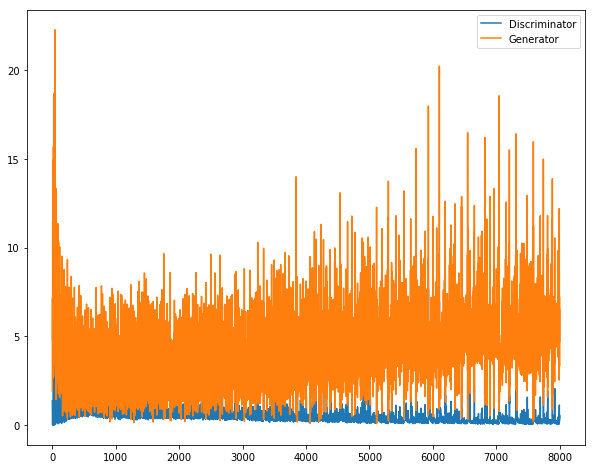

In [8]:
D = discriminator_dc().cuda()
G = generator_dc().cuda()

D_optim = get_adam_optimizer(D)
G_optim = get_adam_optimizer(G)

train(dataloader,D, G, D_optim, G_optim, discriminator_loss, generator_loss,noise_size = NOISE_DIM,EPOCH = 10,show_every = 250)

In [21]:
#generate gif
from imageio import imread, imsave, mimsave
images = []
filenames=sorted((fn for fn in os.listdir(os.path.join(DATA_DIR, OUT_DIR)) if fn.endswith('.png')))
for filename in filenames:
    images.append(imread(os.path.join(DATA_DIR, OUT_DIR,filename)))
    
mimsave(os.path.join(DATA_DIR, OUT_DIR, 'samples.gif'), images, fps=10,duration=0.5)